## LINMA1702 - Projet
# Utilisation optimale d'une pompe à chaleur domestique

###  Notebook pour le rapport final - version 2.1
### <font color="red">Numéro du groupe : (à compléter)</font>
### <font color="red">Membres du groupe : (à compléter)</font>

## Description générale

Une pompe à chaleur permet de chauffer un bâtiment en consommant moins d'énergie qu'au chauffage électrique classique, grâce à un coefficient de performance (COP) supérieur à un. Elle peut également fonctionner de façon réversible, c'est-à-dire qu'elle permet de refroidir en été.

Dans ce projet, on va utiliser une pompe à chaleur pour maintenir le température intérieur d'un bâtiment dans une plage confortable, tout en minimisant le coût de l'électricité consommée.

### Hypothèses et données
- On considère une année entière, qu'on discrétise par intervalles de temps d'une durée de 15 minutes
- Le bâtiment est situé à Montréal, et on dispose de la température extérieure durant chaque intervalle de temps 
- On suppose que la température du bâtiment est homogène, et on s'intéressera uniquement à la valeur qu'elle prend toutes les 15 minutes (on ne s'intéresse donc pas à la dynamique de la température au cours d'un intervalle de temps)
- Durant chaque intervalle de temps la température intérieure évolue en fonction la température externe : la différence de température entre le début et la fin d'un intervalle de temps est proportionnel à la différence entre la température externe et la température interne (le coefficient de proportionnalité dépendant de l'isolation du bâtiment)
- Pendant chaque intervalle de temps on peut choisir d'activer la pompe à chaleur. Plus précisément, on peut décider de la puissance qu'on va utiliser pour la pompe à chaleur, jusqu'à une certaine puissance maximale. Celle-ci va alors prélever de la chaleur extérieure et la transférer à l'intérieur du bâtiment (ou l'inverse si on décide de fonctionne en mode refroidissement, nommé "reverse"). La quantité de chaleur transférée est proportionnelle à la puissance électrique consommée, mais aussi au coefficient de performance (COP).
- La variation de la température du bâtiment causée par l'activation de la pompe à chaleur est proportionnelle à la chaleur/énergie transférée
- Le coefficient de performance de la pompe à chaleur est supposé dépendre uniquement de la température extérieure et du mode de fonctionnement, normal ou reverse.
- Le coût unitaire de l'électricité consommée dépend de l'heure où elle est prélevée (tarif bi-horaire)
   
### Remarque à propos de la modélisation
En général, quand on modélise un problème, on décide d'effectuer certaines hypothèses et/ou approximations. Il y a certainement plusieurs façons tout à fait valides de modéliser le problème, donc pas pas forcément une unique bonne réponse. Vous pouvez interpréter l'énoncé de la façon qui vous convient le mieux du moment qu'elle reste raisonnable. 
(par exemple : l'énoncé suggère de ne pas analyser/de prendre en compte ce qui se passe à l'intérieur d'un intervalle de temps, ce qui est un choix ; aussi : le fonctionnement simultané en mode chauffage et reverse pourrait être a priori permis ou interdit, mais cela change-t-il vraiment les choses ?)

## Imports et fonctions

In [1]:
import numpy as np
import cvxpy as cp
import math
import matplotlib.pyplot as plt
import time

ETA = 0.99
def get_TPlus(T,T_EXT):
    # (T+ - T) = - (1-eta) * (T - Text)
    # T+ = T - (1-eta) * (T - Text)
    return T - (1 - ETA)*(T - T_EXT)

def get_ELEC_COST(timeInQH):
    timeInto24 = (timeInQH%(24*4))//4
    if timeInto24 > 22 or timeInto24 < 7:
        return 0.18
    else:
        return 0.26
      
def getTotalCost(fromTime, num_intervals):    
    return [get_ELEC_COST(fromTime + i) for i in range(num_intervals)]
    
def getTotalCostForX(fromTime, num_intervals, x):
    total_costs = []
    
    for i in range(num_intervals//(x*4)):
        cost = 0
        for j in range(x*4):
            cost += get_ELEC_COST(fromTime + i*x*4 + j)
        total_costs.append(cost)
        
    return total_costs

def getWeeksFromData(data,fromTime=0,weekNumber=float("inf"),goodMean=20):
    numberOfCompleteWeeks = (len(data) - fromTime)//7
    weeks = []
    
    highestVariance = float("-inf")
    interestingWeek = None
    interestingWeek_fromTime = None
    interestingMean = (T_MIN + T_MAX)/2
    
    for weekIndex in range(min(numberOfCompleteWeeks, weekNumber)):
        start = weekIndex*7*24*4 + fromTime
        end = (weekIndex + 1)*7*24*4 + fromTime
        newWeek = data[start:end]
        weeks.append(newWeek)
        variance = np.var(newWeek)
        mean = np.mean(newWeek)
        if abs(goodMean - mean) <= 3:
            if variance > highestVariance:
                highestVariance = variance
                interestingWeek = newWeek
                interestingWeek_fromTime = start
        
    return weeks, interestingWeek, interestingWeek_fromTime
    
T_MIN = 19
T_MAX = 21

In [2]:
# Importation des données et génération des semaines intéréssantes
data = np.load('Temperatures-Montreal.npy')
weeks, interestingWeek, interestingWeek_fromTime = getWeeksFromData(data)

referenceWeek_fromTime = 13050
weeks_, null_, null_ = getWeeksFromData(data,fromTime=13050,weekNumber=1)
referenceWeek = weeks_[0]

c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


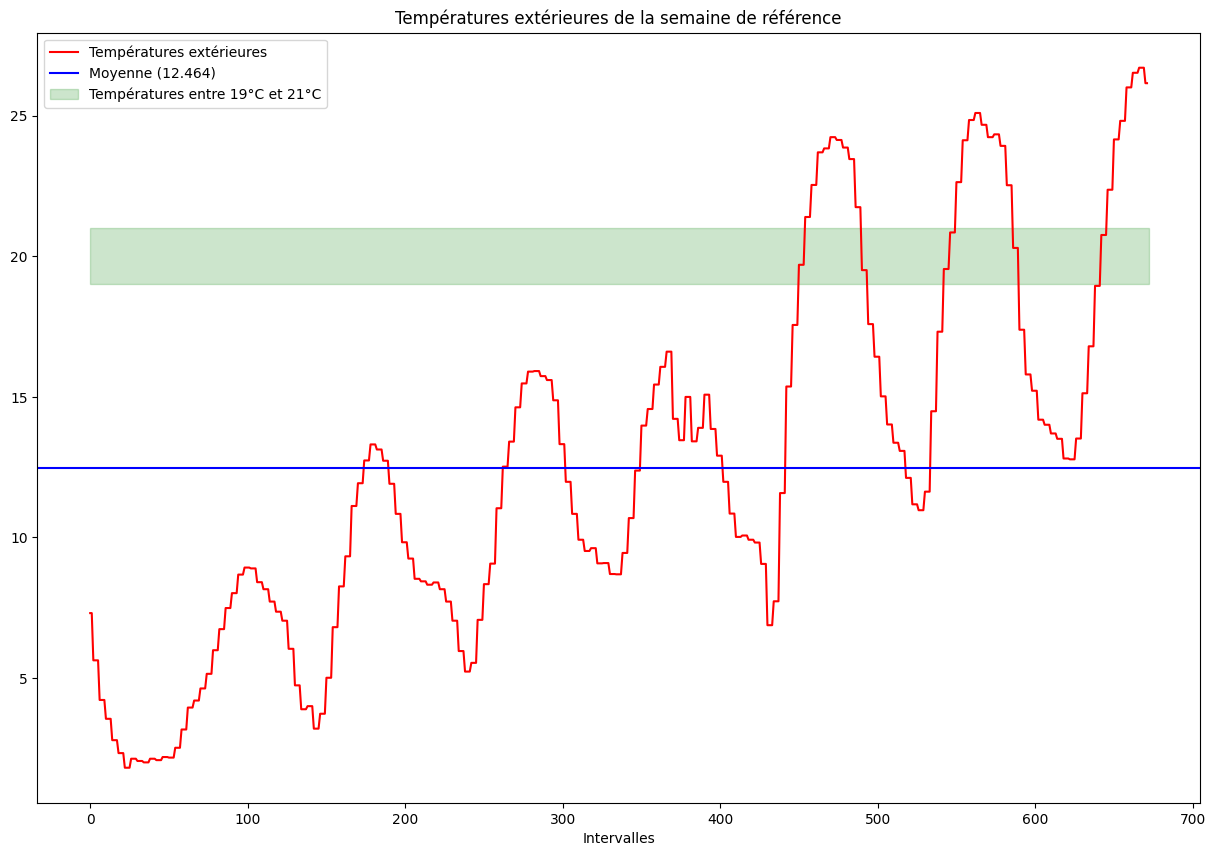

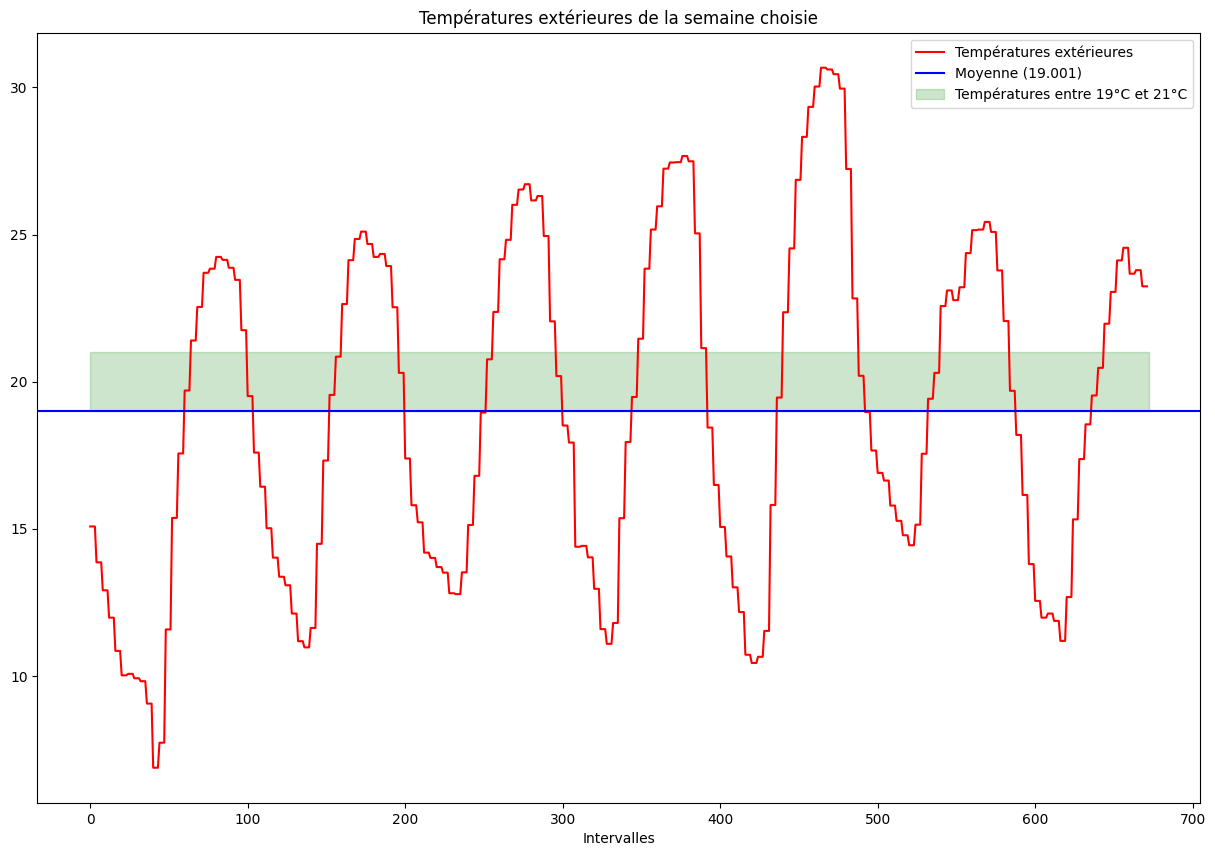

In [3]:
# Graphique des températures extérieures des semaines intéréssantes

# 1) Semaine de référence
fig, ax = plt.subplots(figsize=(15, 10))
X = range(len(referenceWeek))
ax.plot(X, referenceWeek, label="Températures extérieures", color="red")
ax.axhline(y=np.mean(referenceWeek), color='b', linestyle='-', label=f"Moyenne ({round(np.mean(referenceWeek),3)})")
ax.add_patch(plt.Rectangle((0, T_MIN), len(X), (T_MAX - T_MIN), alpha=.2, color="green", label=f"Températures entre {T_MIN}°C et {T_MAX}°C"))
plt.legend()
plt.title("Températures extérieures de la semaine de référence")
plt.xlabel("Intervalles")
plt.savefig("./graphs/referenceWeek.pdf", format="pdf", bbox_inches="tight")
plt.show()


# 2) Semaine avec la plus grande variance et une moyenne intéréssante
fig, ax = plt.subplots(figsize=(15, 10))
X = range(len(interestingWeek))
ax.plot(X, interestingWeek, label="Températures extérieures", color="red")
ax.axhline(y=np.mean(interestingWeek), color='b', linestyle='-', label=f"Moyenne ({round(np.mean(interestingWeek), 3)})")
ax.add_patch(plt.Rectangle((0, T_MIN), len(X), (T_MAX - T_MIN), alpha=.2, color="green", label=f"Températures entre {T_MIN}°C et {T_MAX}°C"))
plt.legend()
plt.title("Températures extérieures de la semaine choisie")
plt.xlabel("Intervalles")
plt.savefig("./graphs/interestingWeek.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Tâches

**Tâche 1** : on souhaite dans un premier temps que la température du bâtiment reste comprise dans une certaine plage admissible de températures, et on cherche à **minimiser le coût total de l'électricité consommée par la pompe à chaleur**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.

Pour des raisons de temps de calcul, votre modèle considérera uniquement une période de 7 jours consécutifs. Il fera l'hypothèse que la température initiale au début de la période est égale à la valeur centrale de la plage admissible, et fera en sorte que la température finale à la fin de la période revienne à la même valeur. Votre code prendra donc en entrée un paramètre indiquant le numéro de l'intervalle de temps qui début la période, qui s'étendra sur $7 \times 24 \times 4 = 672$ intervalles de temps.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- coût minimal + graphique de l'évolution des températures + graphique représentant l'utilisation de la pompe à chaleur (en distinguant le fonctionnement normal du fonctionnement _reverse_) + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- pour deux périodes distinctes (placer les résultats côté à côté) : à gauche une période pré-déterminée (cf. fichier de données), et à droite une seconde période que vous choisirez en fonction de son intérêt
</div>

---

<div class="alert alert-block alert-info"><b>Question 1.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation).
</div>

*minimiser* $c^Tx$<br>
$Ax = b$ <br>
$x >=0 $ <br>

<div class="alert alert-block alert-info"><b>Question 1.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.
</div>

In [4]:
i = 1

toCompute = [
    [referenceWeek, referenceWeek_fromTime],
    [interestingWeek, interestingWeek_fromTime],
]

results = []

CAL_CAP = 1/(0.4)

for case in toCompute:

    outside_temps, fromTime = case
    
    start = time.time()

    # Define the outside temperatures in a predetermined array
    duration = len(outside_temps)
    num_intervals = duration

    # Define the variables
    heat_pump_power_normal = cp.Variable(num_intervals)
    heat_pump_power_reverse = cp.Variable(num_intervals)

    # Define the initial inside temperature
    T_DEBUT = (T_MIN + T_MAX)/2
    T_FINAL_OBJ = T_DEBUT
    
    inside_temp_initial = T_DEBUT

    # Define the constraints
    inside_temp = cp.Variable(num_intervals)
    
    constraints = [
        cp.min(inside_temp) >= T_MIN, 
        cp.max(inside_temp) <= T_MAX
    ]
    constraints += [inside_temp[0] == inside_temp_initial]
    constraints += [inside_temp[num_intervals - 1] == T_FINAL_OBJ]
    constraints += [cp.max(heat_pump_power_normal)  <= 1]
    constraints += [cp.max(heat_pump_power_reverse) <= 1]
    constraints += [cp.min(heat_pump_power_normal) >= 0]
    constraints += [cp.min(heat_pump_power_reverse) >= 0]

    for t in range(1, num_intervals-1):
        T = inside_temp[t-1]
        T_EXT = outside_temps[t]
        T_EVO = get_TPlus(T,T_EXT)
        
        COP_NORMAL = 3 + 10 * abs(math.tanh(T_EXT/100)) * math.tanh(T_EXT/100)
        COP_REVERSE = 3.2

        HEAT_PUMP_TEMP_NORMAL  = COP_NORMAL  * heat_pump_power_normal[t]  * CAL_CAP
        HEAT_PUMP_TEMP_REVERSE = COP_REVERSE * heat_pump_power_reverse[t] * CAL_CAP * (-1)

        HEAT_PUMP_TEMP = HEAT_PUMP_TEMP_NORMAL + HEAT_PUMP_TEMP_REVERSE
        
        constraints += [inside_temp[t] == (T_EVO + HEAT_PUMP_TEMP)]
                
    # Define the objective function to minimize the total cost
    total_costs = getTotalCost(fromTime, num_intervals)
    obj = cp.sum(cp.multiply(total_costs, heat_pump_power_normal)) + cp.sum(cp.multiply(total_costs, heat_pump_power_reverse))

    # Define the problem
    problem = cp.Problem(cp.Minimize(obj), constraints)

    # Solve the problem
    problem.solve() # qcp=True
    
    # Retrieve the dual values
    SensibilityOfTminChange = constraints[0].dual_value
    SensibilityOfTmaxChange = constraints[1].dual_value
    
    # Retrieve the optimal values
    optimal_heat_pump_power_normal  = heat_pump_power_normal.value
    optimal_heat_pump_power_reverse = heat_pump_power_reverse.value
    optimal_inside_temps = inside_temp.value

    end = time.time()
    
    results.append({
        "totalCost": obj.value,
        "outside_temps": outside_temps,
        "optimal_inside_temps": optimal_inside_temps,
        "optimal_heat_pump_power_normal": optimal_heat_pump_power_normal,
        "optimal_heat_pump_power_reverse": optimal_heat_pump_power_reverse,
        "optimal_heat_pump_power": [(optimal_heat_pump_power_normal[i] + optimal_heat_pump_power_reverse[i]) for i in range(len(optimal_heat_pump_power_reverse))],
        "calcDuration": (end - start),
        "SensibilityOfTminChange": SensibilityOfTminChange,
        "SensibilityOfTmaxChange": SensibilityOfTmaxChange
    })
    
    print(f"done! {i}/{len(toCompute)} : {obj.value}")
    i+=1

done! 1/2 : 1.2923319279528074
done! 2/2 : 0.2566169844618198


Optimal Total Cost:  1.2923319279528074
Temps de calcul: 1.6605002880096436s


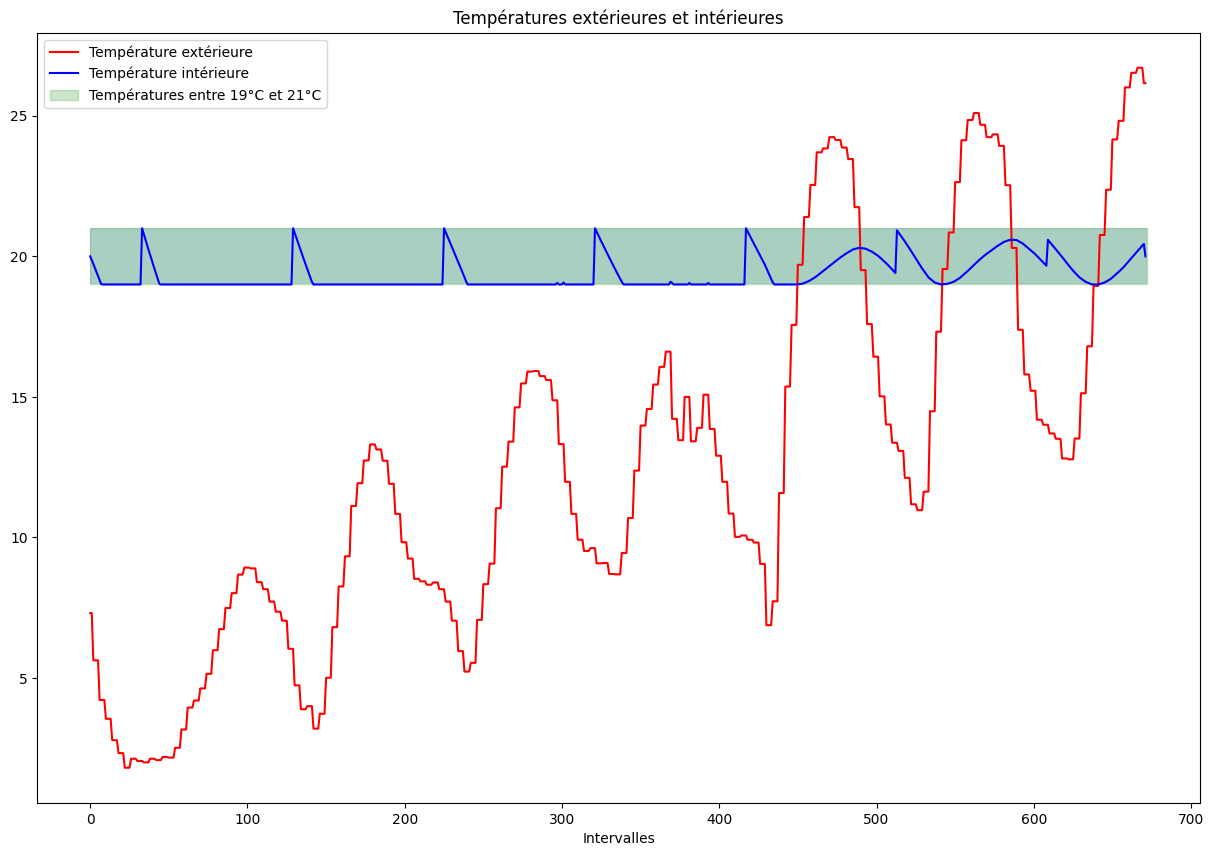

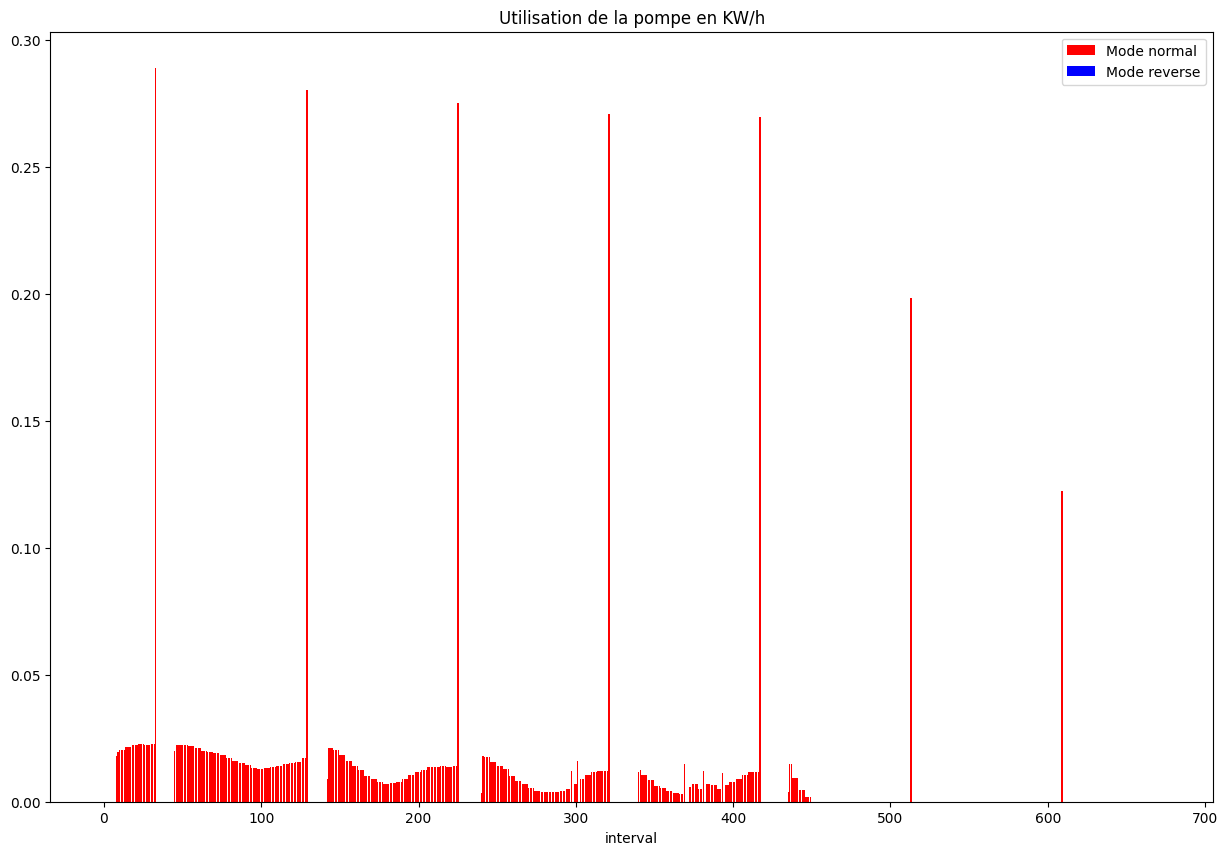

-----------------------------------
Optimal Total Cost:  0.2566169844618198
Temps de calcul: 1.565500020980835s


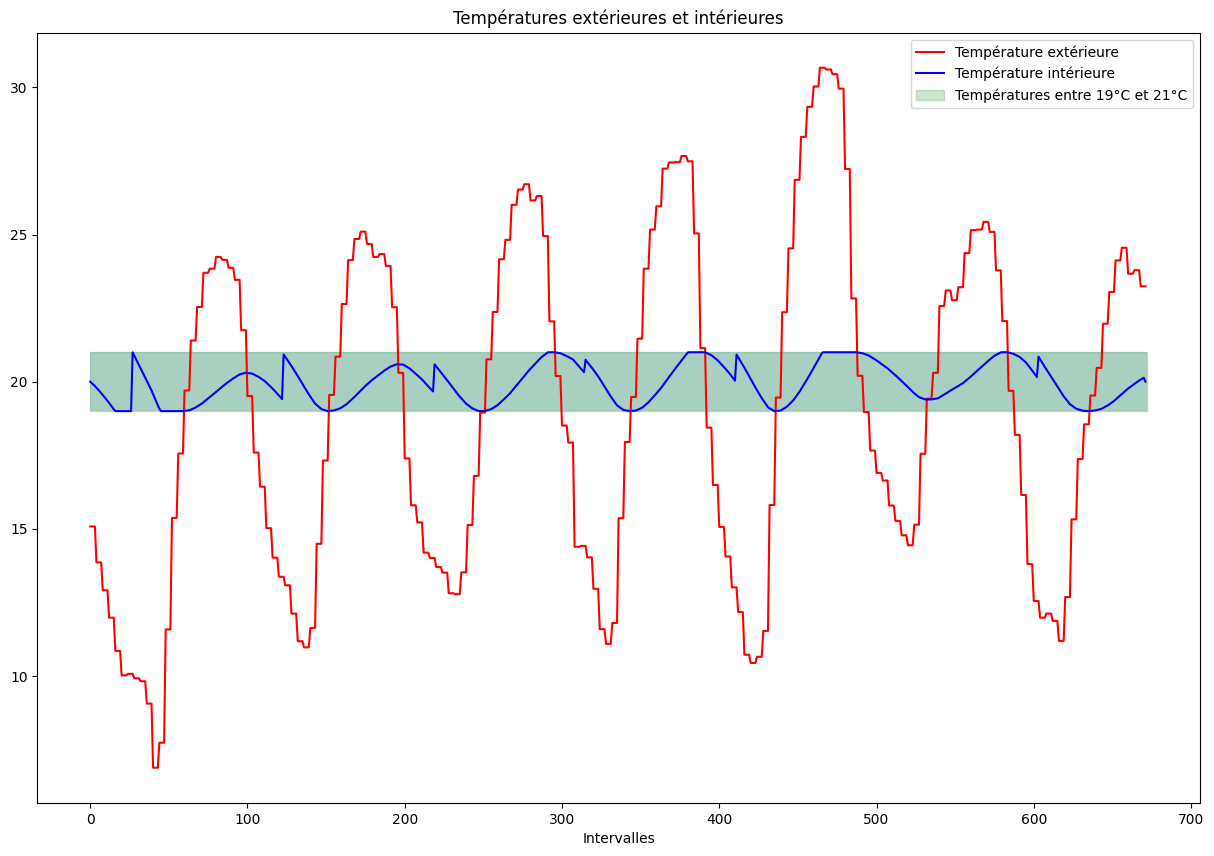

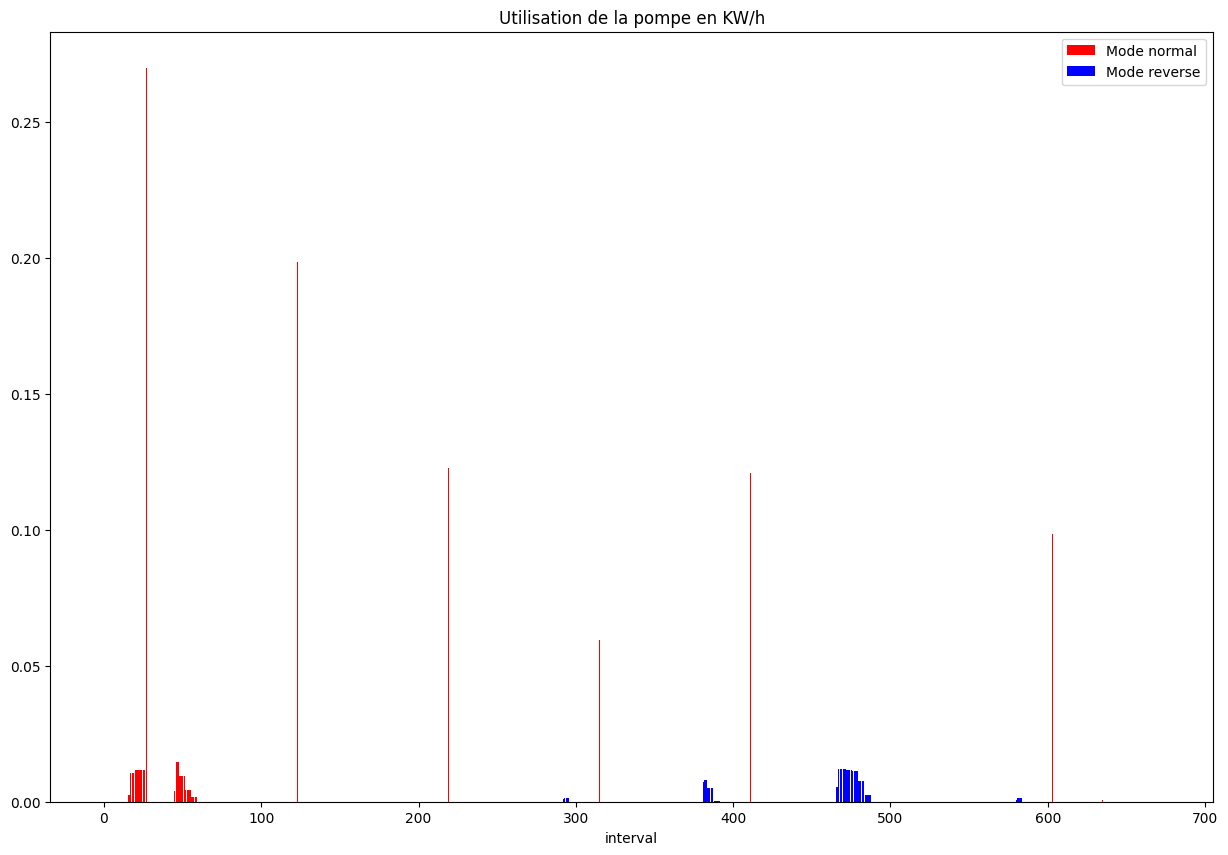

-----------------------------------


In [5]:
BUDGETS = []

for i,result in enumerate(results):
    N = len(result["outside_temps"])
    
    BUDGETS.append(result["totalCost"])

    # 1) Cout minimal
    print("Optimal Total Cost: ", result["totalCost"])
    print(f"Temps de calcul: { result['calcDuration'] }s")
    
    # 2) Graphe des températures extérieures et intérieures
    x = range(N)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2))
    ax.plot(x, result["outside_temps"], label="Température extérieure", color="red")
    ax.plot(x, result["optimal_inside_temps"], label="Température intérieure", color="blue")
    ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2, color="green", label=f"Températures entre {T_MIN}°C et {T_MAX}°C"))
    plt.legend()
    plt.title("Températures extérieures et intérieures")
    plt.xlabel("Intervalles")
    plt.savefig(f"./graphs/task1_temp_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # 3) Graphe de l'utilisation de la pompe à chaleur
    x = range(N)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(x, result["optimal_heat_pump_power_normal"], label="Mode normal", color="red")
    ax.bar(x, result["optimal_heat_pump_power_reverse"], label="Mode reverse", color="blue")
    plt.legend()
    plt.title("Utilisation de la pompe en KW/h")
    plt.xlabel("interval")
    plt.savefig(f"./graphs/task1_usage_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    print("-----------------------------------")

<div class="alert alert-block alert-info"><b>Question 1.3</b> :<br> 
    A partir de certaines informations fournies par le solver (et donc sans effectuer de nouveau calcul) et de la théorie vue au cours, prédisez l'effet sur le coût optimal d'une diminution de la tempéature minimale admissible Tmin. Faites de même pour une augmentation de la température maximale admissible Tmax. 
    Votre prédiction consiste en un formule pour le coût optimal en fonction des deux variations de température Tmin et Tmax. Commentez cette prédiction (en particulier : est-elle valide pour n'importe quelle variation des températures ?).
</div>

La diminution de Tmin et l'augmentation et Tmax correspondent à une modification du vecteur *b*. Le cours 6 décrit cette situation et explique dans l'interprétation 2 que les variables duales fournissent les valeurs marginales d'un problème. C'est à dire que si Tmin diminue de *k* et que **la base reste inchangée**: l'objectif augmente de *k*$*$*valeur marginale de la contrainte Tmin*. La même logique s'applique pour Tmax.

In [6]:
print("Semaine de référence")
SensibilityOfTminChange = results[0]["SensibilityOfTminChange"]
SensibilityOfTmaxChange = results[0]["SensibilityOfTmaxChange"]
print(f"Valeur marginale de Tmin: {SensibilityOfTminChange}")
print(f"Valeur marginale de Tmax: {SensibilityOfTmaxChange}")

print()

print("Semaine choisie")
SensibilityOfTminChange = results[1]["SensibilityOfTminChange"]
SensibilityOfTmaxChange = results[1]["SensibilityOfTmaxChange"]
print(f"Valeur marginale de Tmin: {SensibilityOfTminChange}")
print(f"Valeur marginale de Tmax: {SensibilityOfTmaxChange}")

Semaine de référence
Valeur marginale de Tmin: 0.2211344175657079
Valeur marginale de Tmax: 0.029065570621978513

Semaine choisie
Valeur marginale de Tmin: 0.22303280754819352
Valeur marginale de Tmax: 0.16116214008366436


<div class="alert alert-block alert-info"><b>Question 1.4</b> :<br> 
   Démontrez que, dans toute solution optimale de ce modèle, l'activation simultanée du chauffage et du mode reverse durant la même période de temps est impossible.
</div>

In [7]:
# TODO !

<div class="alert alert-block alert-info"><b>Question 1.5</b> :<br> 
    Modifiez votre modèle de façon à tenir compte des deux nouvelles contraintes suivantes :<br>
    - si la pompe à chaleur est utilisée (dans un mode ou dans l'autre), elle l'est au moins à 25% de sa puissance maximale. Il n'est donc plus possible d'utiliser la pompe à chaleur à très faible puissance.
<br>
    - si on décide d'allumer (ou d'éteindre) la pompe à chaleur, elle reste allumée (ou éteinte) sur une période de x heures consécutives. Ces périodes sont fixes : par exemple, si x=4h, il s'agit de [0h-4h], [4h-8h], [8h-12h], [12h-16h], etc. pour chaque journée.<br>
    Le nouveau modèle sera toujours obligatoirement linéaire, mais pourra faire appel à des variables discrètes. 
    Donnez votre formulation, et commentez brièvement.
</div>

In [8]:
shouldRun = False

if shouldRun:
    i = 1

    toCompute = [
        [referenceWeek, referenceWeek_fromTime],
        [interestingWeek, interestingWeek_fromTime],
    ]

    results = []

    CAL_CAP = 1/(0.4)

    for case in toCompute:

        outside_temps, fromTime = case

        start = time.time()

        x = 4
        NB15MinsInX = 4*x
        numberOfCycleStart = num_intervals//NB15MinsInX

        # Define the outside temperatures in a predetermined array
        duration = len(outside_temps)
        num_intervals = duration

        # Define the variables
        heat_pump_power_normal = cp.Variable(numberOfCycleStart)
        heat_pump_power_reverse = cp.Variable(numberOfCycleStart)
        heat_pump_power_normal_isActive = cp.Variable(numberOfCycleStart, boolean=True)
        heat_pump_power_reverse_isActive = cp.Variable(numberOfCycleStart, boolean=True)

        # Define the initial inside temperature
        T_DEBUT = (T_MIN + T_MAX)/2
        T_FINAL_OBJ = T_DEBUT

        inside_temp_initial = T_DEBUT

        # Define the constraints
        inside_temp = cp.Variable(num_intervals)

        constraints = [
            cp.min(inside_temp) >= T_MIN, # Respect T_MIN
            cp.max(inside_temp) <= T_MAX, # Respect T_MAX
            inside_temp[0] == inside_temp_initial, # Initial Temp = ObjTemp
            inside_temp[num_intervals - 1] == T_FINAL_OBJ, # Last Temp = ObjTemp
            cp.min(heat_pump_power_normal) >= 0,  # Minimum power of normal mode is 1
            cp.min(heat_pump_power_reverse) >= 0, # Minimum power of reverse mode is 1
        ]

        for t in range(1, num_intervals-1):

            cycleIndex = t//NB15MinsInX

            T = inside_temp[t-1]
            T_EXT = outside_temps[t]
            T_EVO = get_TPlus(T,T_EXT)

            COP_NORMAL = 3 + 10 * abs(math.tanh(T_EXT/100)) * math.tanh(T_EXT/100)
            COP_REVERSE = 3.2

            HEAT_PUMP_TEMP_NORMAL  = COP_NORMAL  * heat_pump_power_normal[cycleIndex]  * CAL_CAP
            HEAT_PUMP_TEMP_REVERSE = COP_REVERSE * heat_pump_power_reverse[cycleIndex] * CAL_CAP * (-1)

            HEAT_PUMP_TEMP = HEAT_PUMP_TEMP_NORMAL + HEAT_PUMP_TEMP_REVERSE

            constraints += [
                inside_temp[t] == (T_EVO + HEAT_PUMP_TEMP),

                heat_pump_power_normal[cycleIndex] <= heat_pump_power_normal_isActive[cycleIndex],
                heat_pump_power_normal[cycleIndex] >= 0.25*heat_pump_power_normal_isActive[cycleIndex],

                heat_pump_power_reverse[cycleIndex] <= heat_pump_power_reverse_isActive[cycleIndex],
                heat_pump_power_reverse[cycleIndex] >= 0.25*heat_pump_power_reverse_isActive[cycleIndex],      
            ]   

        # Define the objective function to minimize the total cost
        total_costs = getTotalCostForX(fromTime, num_intervals, x)
        obj = cp.sum(cp.multiply(total_costs, (heat_pump_power_normal + heat_pump_power_reverse)))

        # Define the problem
        problem = cp.Problem(cp.Minimize(obj), constraints)

        print("Starting !")
        # Solve the problem
        problem.solve() # qcp=True

        # Retrieve the dual values
        SensibilityOfTminChange = constraints[0].dual_value
        SensibilityOfTmaxChange = constraints[1].dual_value

        # Retrieve the optimal values
        optimal_heat_pump_power_normal  = heat_pump_power_normal.value
        optimal_heat_pump_power_reverse = heat_pump_power_reverse.value
        optimal_inside_temps = inside_temp.value

        end = time.time()

        results.append({
            "totalCost": obj.value,
            "outside_temps": outside_temps,
            "optimal_inside_temps": optimal_inside_temps,
            "optimal_heat_pump_power_normal": optimal_heat_pump_power_normal,
            "optimal_heat_pump_power_reverse": optimal_heat_pump_power_reverse,
            "optimal_heat_pump_power": [(optimal_heat_pump_power_normal[i] + optimal_heat_pump_power_reverse[i]) for i in range(len(optimal_heat_pump_power_reverse))],
            "calcDuration": (end - start),
            "SensibilityOfTminChange": SensibilityOfTminChange,
            "SensibilityOfTmaxChange": SensibilityOfTmaxChange
        })

        print(f"done! {i}/{len(toCompute)} : {obj.value} ({(end - start)}s)")
        i+=1

<div class="alert alert-block alert-info"><b>Question 1.6</b> :<br> 
    Résolvez ce nouveau modèle, affichez les résultats et commentez (en particulier le temps de calcul). Choissisez d'abord une valeur x=4h, puis x=2h.
</div>

In [9]:
shouldRun = False

if shouldRun:
    for i,result in enumerate(results):
        N = len(result["outside_temps"])

        # 1) Cout minimal
        print("Optimal Total Cost: ", result["totalCost"])
        print(f"Temps de calcul: { result['calcDuration'] }s")

        # 2) Graphe des températures extérieures et intérieures
        X = range(N)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2))
        ax.plot(X, result["outside_temps"], label="Température extérieure", color="red")
        ax.plot(X, result["optimal_inside_temps"], label="Température intérieure", color="blue")
        ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2, color="green", label=f"Températures entre {T_MIN}°C et {T_MAX}°C"))
        plt.legend()
        plt.title("Températures extérieures et intérieures")
        plt.xlabel("Intervalles")
        plt.savefig(f"./graphs/task1_temp_{i}.pdf", format="pdf", bbox_inches="tight")
        plt.show()

        # 3) Graphe de l'utilisation de la pompe à chaleur
        X = range(N)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.bar(X, np.repeat(result["optimal_heat_pump_power_normal"], x*4), label="Mode normal", color="red")
        ax.bar(X, np.repeat(result["optimal_heat_pump_power_reverse"], x*4), label="Mode reverse", color="blue")
        plt.legend()
        plt.title("Utilisation de la pompe en KW/h")
        plt.xlabel("interval")
        plt.savefig(f"./graphs/task1_usage_{i}.pdf", format="pdf", bbox_inches="tight")
        plt.show()

        print("-----------------------------------")

<div class="alert alert-block alert-info"><b>Question 1.7</b> :<br> 
    Décrivez comment on pourrait apporter les modifications suivantes au nouveau modèle de la Question 1.5, sans les implémenter : <br>
    (a) tenir compte d'un coût fixe supplémentaire à payer pour chaque intervalle de temps où la pompe à chaleur est utilisée<br>
    (b) empêcher le nombre total d'allumages de la pompe à chaleur à ne pas dépasser une certaine valeur maximale (un allumage = passage de l'état 'éteint' lors d'un invervalle de temps à l'état 'allumé' lors de l'intervalle de temps suivant)<br>
    (c) dans ce nouveau modèle il n'est plus nécessairement impossible d'observer dans une solution optimale l'activation simultanée du chauffage et du mode reverse au cours du même intervalle de temps : expliquez pourquoi, et proposez une contrainte permettant d'éliminer cette possibilité d'activation simultanée.
</div>

### a) Cout fixe supplémentaire
Pour chaque intervalle de $x$ heure(s), on définit une variables qui est égale à $1$ si la pompe est allumée durant cette intervalle ou $0$ si elle est éteinte (mode normal ou reverse). La fonction objectif utilise $cp.sum(...)$ pour sommer ces variables. La somme est ensuite multipliée par la coût fixe.

<hr>

### b) Nombre maximum d'allumage
Pour chaque intervalle de $x$ heure(s), on définit une variables qui est égale à $1$ si la pompe est allumée durant cette intervalle ou $0$ si elle est éteinte (mode normal ou reverse). En utilisant une contrainte $cp.sum(...) <= ALL\_MAX$ on peut limiter la somme de ces allumages à $ALL\_MAX$.

<hr>

### c) Activation simultanée du mode normal et du mode reverse
Cela vient du fait qu'il est souvent moins cher de chauffer plus fort quand cela coûte peu cher que de chauffer continuellement (et donc aussi pendant les périodes où l'électricité coûte plus chère). En effet, on peut voir dans les graphes du point 1.6 (les graphes pairs) que la solution optimale revient à chauffer en utilisant une valeur $>0.25$ kW tout en refroidissant en utilisant exactement $0.25$ kW (valeur minimum pour l'activation de la pompe). La soustraction de la chaleur enlevée à la chaleur ajoutée fournit au domicile de la chaleur tout en profitant du coût de l'électricité le plus avantageux. 
<br><br>
Une contrainte qui permettrait d'éviter l'activation simultanée du mode normal et du mode reverse est que la somme des booléans "mode normal actif" et "mode reverse actif" soit tout le temps inférieur ou égal à 1 (si il vaut 2 les deux modes sont actifs en même temps).

**Tâche 2** : on souhaite réduire le coût d'utilisation de la pompe à chaleur, et on va fixer le budget maximal à une certaine proportion du coût minimal identifié lors de la première tâche. Pour diminuer les coût, on va permettre aux températures de sortir de la plage admissible définie plus haut (on abandonne aussi la contrainte sur la température finale, qui devient libre). On va cependant alors comptabiliser la quantité d'_inconfort_ éventuellement subi durant chaque intervalle de temps, qui sera proportionnel au dépassement de la température maximale admissible, ou au dépassement par le bas de la température minimale admissible. On cherche alors à **minimiser l'inconfort total** (somme des inconforts sur toute la période considérée) **tout en respectant la contrainte de budget**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.


<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- inconfort minimal + même graphiques que pour tâche 1 + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées lors de la tâche 1
</div>

---

<div class="alert alert-block alert-info"><b>Question 2.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation).
</div>

In [10]:
# TODO !

<div class="alert alert-block alert-info"><b>Question 2.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.modélisation/reformulation)  
</div>

In [11]:
i = 1
toCompute = [
    [referenceWeek, referenceWeek_fromTime],
    [interestingWeek, interestingWeek_fromTime],
]
fracs = []

results_task2 = {}

steps = 2
stepSize = 1/steps
for i in range(0,steps+1):
    fracs.append(stepSize*i)
    results_task2[str(stepSize*i)] = []

i=0
for j,budgetFrac in enumerate(fracs):
    for i,case in enumerate(toCompute):

        outside_temps, fromTime = case

        start = time.time()

        # Define the outside temperatures in a predetermined array
        duration = len(outside_temps)
        num_intervals = duration

        # Define the variables
        heat_pump_power_normal  = cp.Variable(num_intervals)
        heat_pump_power_reverse = cp.Variable(num_intervals)

        # Define the initial inside temperature
        T_DEBUT = (T_MIN + T_MAX)/2
        T_FINAL_OBJ = T_DEBUT
        MAX_BUDGET = BUDGETS[i]*budgetFrac

        print(f"Starting with max budget: {MAX_BUDGET}$")
        inside_temp_initial = T_DEBUT
        total_costs = getTotalCost(fromTime, num_intervals)
        inside_temp = cp.Variable(num_intervals)

        # Define the constraints
        total_cost = cp.sum(cp.multiply(total_costs, heat_pump_power_normal)) + cp.sum(cp.multiply(total_costs, heat_pump_power_reverse))
        constraints = [inside_temp[0] == inside_temp_initial]
        constraints += [cp.max(heat_pump_power_normal)  <= 1]
        constraints += [cp.max(heat_pump_power_reverse) <= 1]
        constraints += [cp.min(heat_pump_power_normal) >= 0]
        constraints += [cp.min(heat_pump_power_reverse) >= 0]
        constraints += [total_cost <= MAX_BUDGET]

        for t in range(1, num_intervals-1):
            T = inside_temp[t-1]
            T_EXT = outside_temps[t]
            T_EVO = get_TPlus(T,T_EXT)

            COP_NORMAL = 3 + 10 * abs(math.tanh(T_EXT/100)) * math.tanh(T_EXT/100)
            COP_REVERSE = 3.2

            HEAT_PUMP_TEMP_NORMAL  = COP_NORMAL  * heat_pump_power_normal[t]  * CAL_CAP
            HEAT_PUMP_TEMP_REVERSE = COP_REVERSE * heat_pump_power_reverse[t] * CAL_CAP * (-1)

            HEAT_PUMP_TEMP = HEAT_PUMP_TEMP_NORMAL + HEAT_PUMP_TEMP_REVERSE

            constraints += [
                inside_temp[t] == (T_EVO + HEAT_PUMP_TEMP),
            ]

        def calcInc(arr):
            inc = 0
            for temp in arr:
                inc += 3 * cp.pos((T_MIN - temp))
                inc += 1 * cp.pos((temp - T_MAX))
            return inc

        # Define the objective function to minimize the total cost
        obj = calcInc(inside_temp)

        # Define the problem
        problem = cp.Problem(cp.Minimize(obj), constraints)

        # Solve the problem
        problem.solve() # qcp=True

        # Retrieve the optimal values
        optimal_inside_temps = inside_temp.value

        end = time.time()

        results_task2[str(budgetFrac)].append({
            "totalCost": total_cost.value,
            "maxBudget": MAX_BUDGET,
            "totalInconfort": obj.value,
            "outside_temps": outside_temps,
            "optimal_inside_temps": optimal_inside_temps,
            "optimal_heat_pump_power_normal": heat_pump_power_normal.value,
            "optimal_heat_pump_power_reverse": heat_pump_power_reverse.value,
            "calcDuration": (end - start)
        })

        print(f"done! {i+1}/{len(toCompute)} | {obj.value}")
    print(f"budget done! {j+1}/{len(results_task2.keys())}\n")


Starting with max budget: 0.0$


c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


done! 1/2 | 12813.882751846955
Starting with max budget: 0.0$
done! 2/2 | 1153.530415976008
budget done! 1/3

Starting with max budget: 0.6461659639764037$


c:\users\victo\appdata\local\programs\python\python37\lib\site-packages\cvxpy\problems\problem.py:1386: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


done! 1/2 | 4523.9924709400175
Starting with max budget: 0.1283084922309099$
done! 2/2 | 140.57856684804625
budget done! 2/3

Starting with max budget: 1.2923319279528074$
done! 1/2 | 0.0
Starting with max budget: 0.2566169844618198$
done! 2/2 | 0.0
budget done! 3/3



dict_keys(['0.0', '0.5', '1.0'])
Optimal Total Cost:  0.646165971465935
Max budget:  0.6461659639764037
Total inconfort:  4523.9924709400175
Temps de calcul: 3.675499677658081s


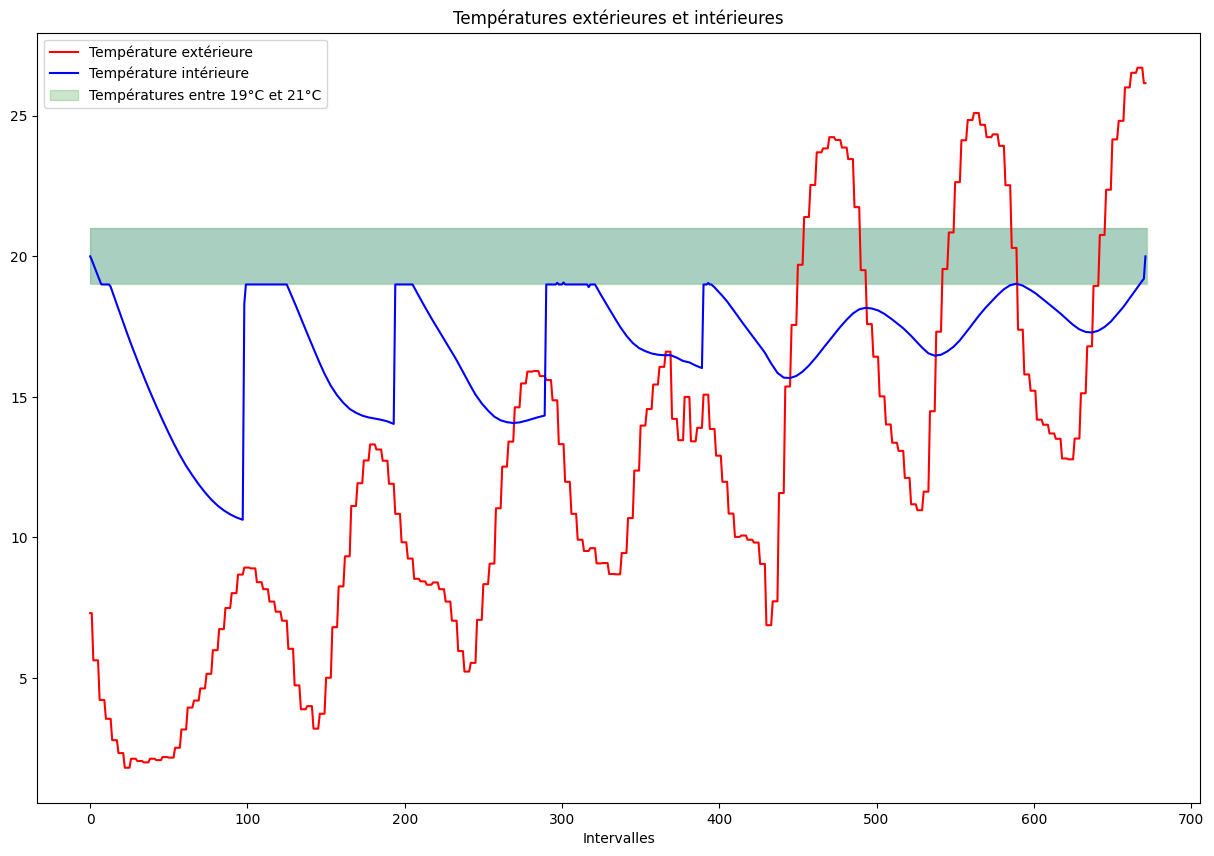

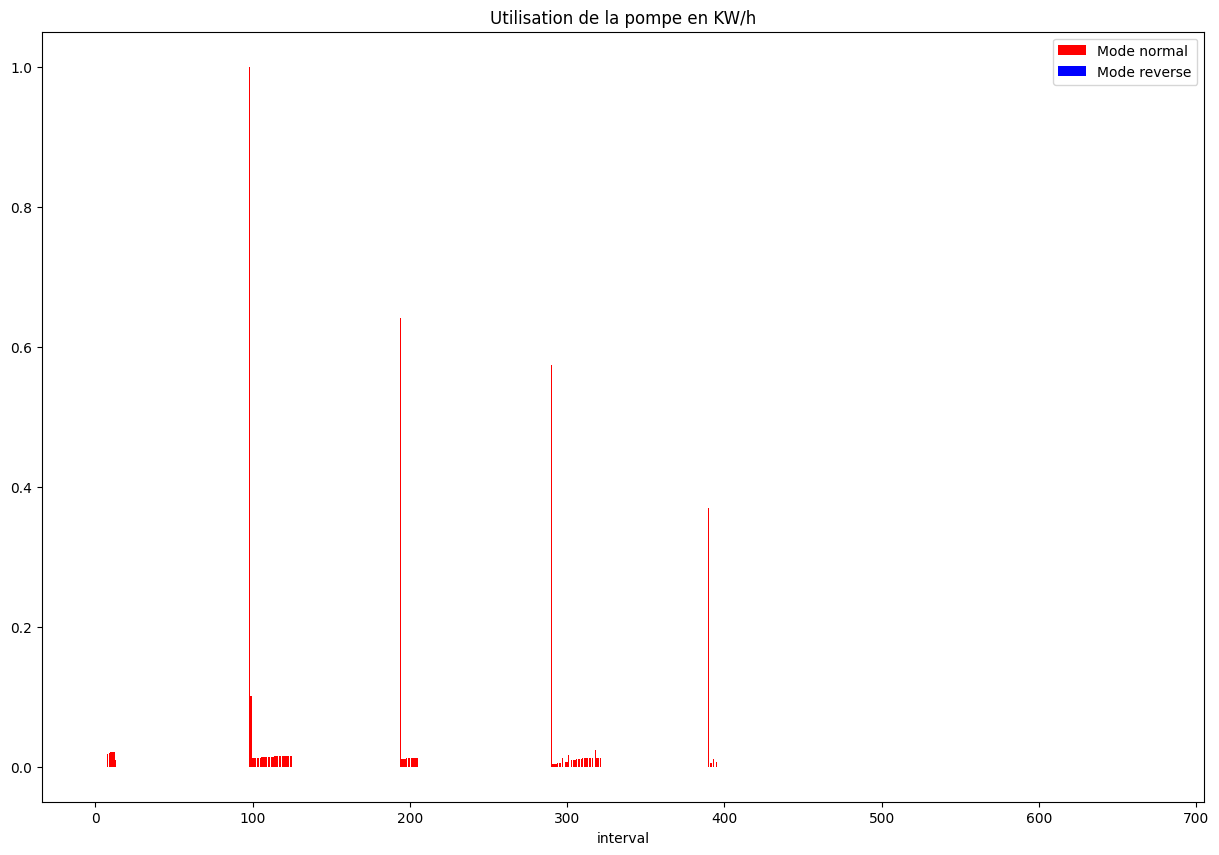

-----------------------------------
Optimal Total Cost:  0.12830849805933717
Max budget:  0.1283084922309099
Total inconfort:  140.57856684804625
Temps de calcul: 3.611499547958374s


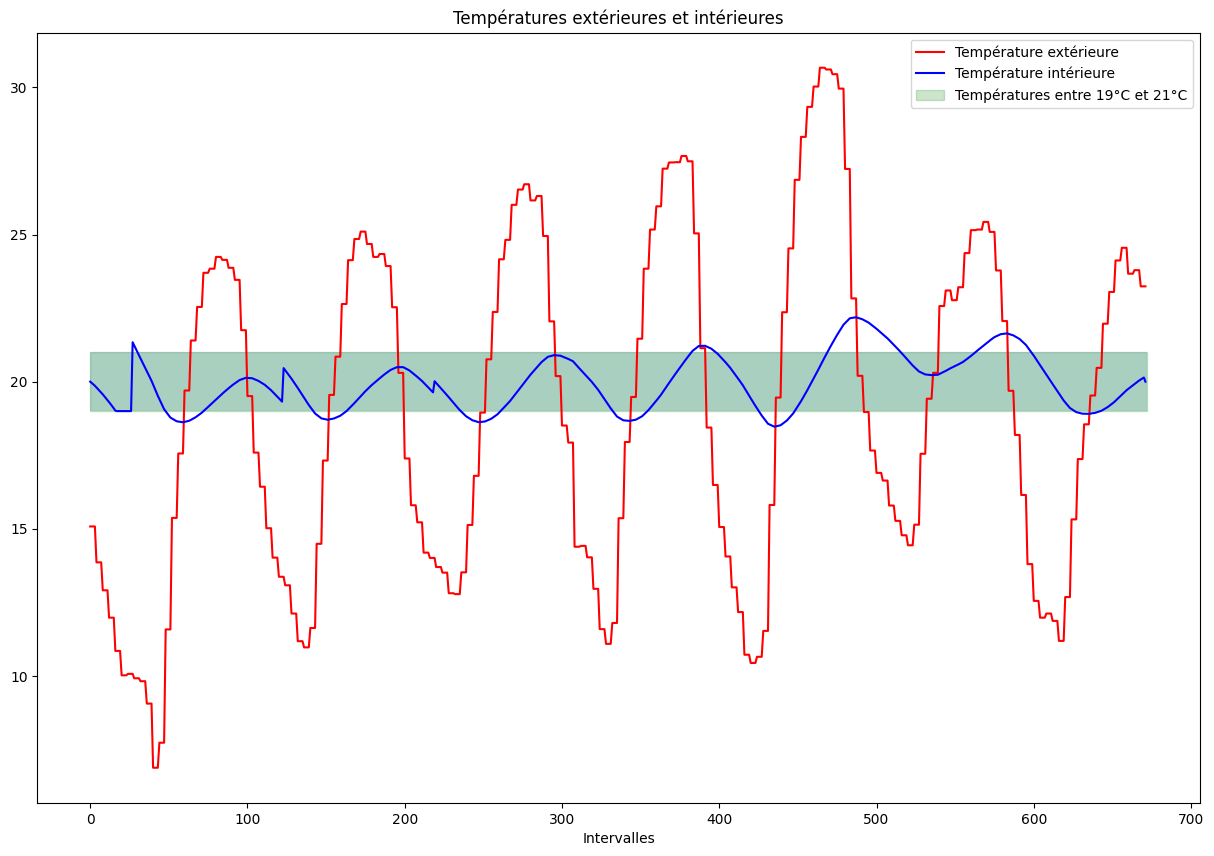

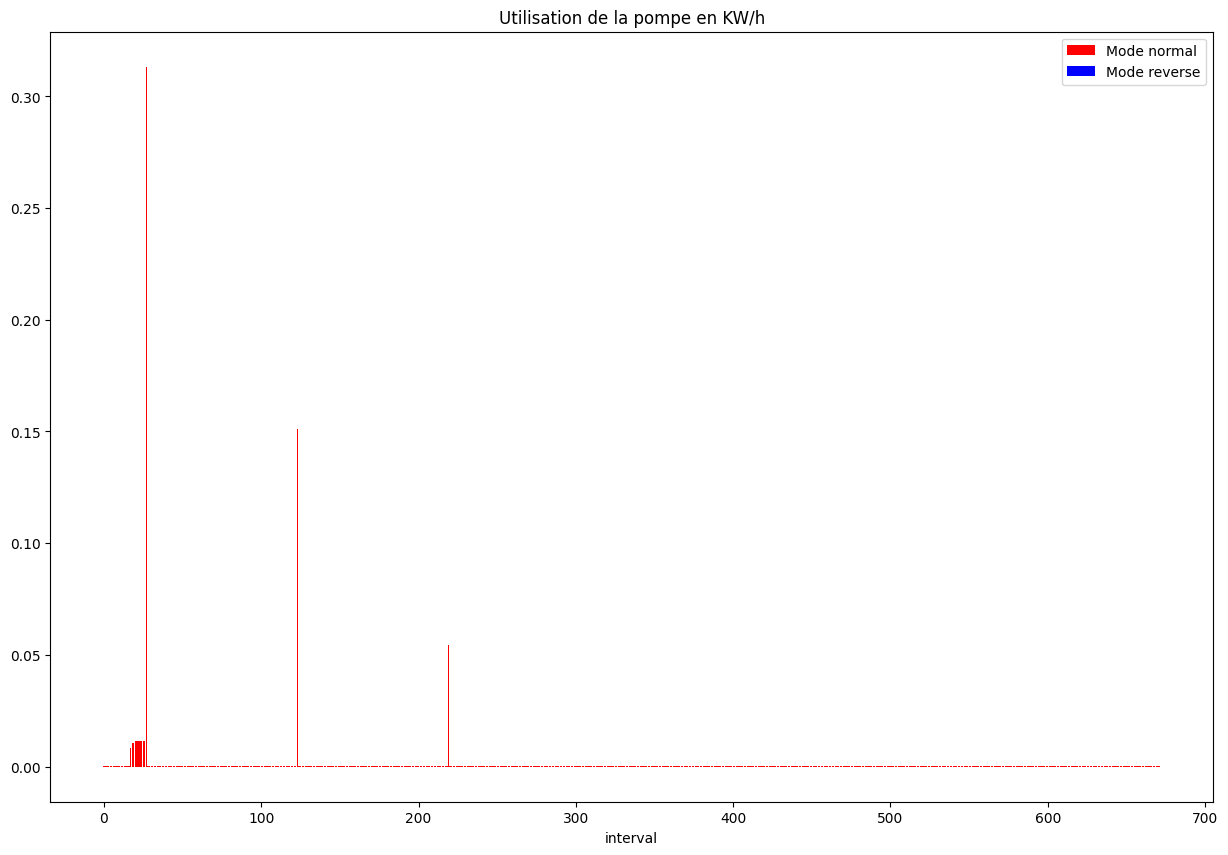

-----------------------------------


In [14]:
print(results_task2.keys())
for i,result in enumerate(results_task2["0.5"]):
    N = len(result["outside_temps"])

    # 1) Cout minimal
    print("Optimal Total Cost: ", result["totalCost"])
    print("Max budget: ", result["maxBudget"])
    print("Total inconfort: ", result["totalInconfort"])
    print(f"Temps de calcul: { result['calcDuration'] }s")

    # 2) Graphe des températures extérieures et intérieures
    x = range(N)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2))
    ax.plot(x, result["outside_temps"], label="Température extérieure", color="red")
    ax.plot(x, result["optimal_inside_temps"], label="Température intérieure", color="blue")
    ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2, color="green", label=f"Températures entre {T_MIN}°C et {T_MAX}°C"))
    plt.legend()
    plt.title("Températures extérieures et intérieures")
    plt.xlabel("Intervalles")
    plt.savefig(f"./graphs/task2_temp_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # 3) Graphe de l'utilisation de la pompe à chaleur
    x = range(N)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(x, result["optimal_heat_pump_power_normal"], label="Mode normal", color="red")
    ax.bar(x, result["optimal_heat_pump_power_reverse"], label="Mode reverse", color="blue")
    plt.legend()
    plt.title("Utilisation de la pompe en KW/h")
    plt.xlabel("interval")
    plt.savefig(f"./graphs/task2_usage_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    print("-----------------------------------")

On remplace à présent la notion d'inconfort décrite ci-dessus par une pénalisation quadratique : à présent l'inconfort  est proportionnel au *carré* du dépassement de la température maximale admissible, ou au *carré* du dépassement par le bas de la température minimale admissible (les coefficients de proportionnalité restent identiques).

<div class="alert alert-block alert-info"><b>Question 2.3</b> :<br> 
    Modélisez ce nouveau problème de façon linéaire, en utilisant une approximation. Cette approximation pourra par exemple être basée sur des tangentes  (choisissez un nombre pas trop élevé, par exemple 5). Expliquez votre technique de modélisation. Résolvez ce modèle approché, affichez les solutions et commentez (en particulier l'effet sur la solution par rapport au modèle d'inconfort initial).
</div>

In [44]:
i = 1
toCompute = [
    [referenceWeek, referenceWeek_fromTime],
    #[interestingWeek, interestingWeek_fromTime],
]
fracs = []

results_task2 = {}

steps = 2
stepSize = 1/steps
for i in range(1,steps): # range(1,steps+1)
    fracs.append(stepSize*i)
    results_task2[str(stepSize*i)] = []

i=0
for j,budgetFrac in enumerate(fracs):
    for i,case in enumerate(toCompute):

        outside_temps, fromTime = case

        start = time.time()

        # Define the outside temperatures in a predetermined array
        duration = len(outside_temps)
        num_intervals = duration

        # Define the variables
        heat_pump_power_normal  = cp.Variable(num_intervals)
        heat_pump_power_reverse = cp.Variable(num_intervals)

        # Define the initial inside temperature
        T_DEBUT = (T_MIN + T_MAX)/2
        T_FINAL_OBJ = T_DEBUT
        MAX_BUDGET = BUDGETS[i]*budgetFrac

        print(f"Starting with max budget: {MAX_BUDGET}$")
        inside_temp_initial = T_DEBUT
        total_costs = getTotalCost(fromTime, num_intervals)
        inside_temp = cp.Variable(num_intervals)

        A = cp.Variable(num_intervals)
        B = cp.Variable(num_intervals)
        
        # Define the constraints
        total_cost = cp.sum(cp.multiply(total_costs, heat_pump_power_normal)) + cp.sum(cp.multiply(total_costs, heat_pump_power_reverse))
        constraints = [inside_temp[0] == inside_temp_initial]
        constraints += [cp.max(heat_pump_power_normal)  <= 1]
        constraints += [cp.max(heat_pump_power_reverse) <= 1]
        constraints += [cp.min(heat_pump_power_normal) >= 0]
        constraints += [cp.min(heat_pump_power_reverse) >= 0]
        constraints += [total_cost <= MAX_BUDGET]

        for t in range(1, num_intervals-1):
            T = inside_temp[t-1]
            T_EXT = outside_temps[t]
            T_EVO = get_TPlus(T,T_EXT)

            COP_NORMAL = 3 + 10 * abs(math.tanh(T_EXT/100)) * math.tanh(T_EXT/100)
            COP_REVERSE = 3.2

            HEAT_PUMP_TEMP_NORMAL  = COP_NORMAL  * heat_pump_power_normal[t]  * CAL_CAP
            HEAT_PUMP_TEMP_REVERSE = COP_REVERSE * heat_pump_power_reverse[t] * CAL_CAP * (-1)

            HEAT_PUMP_TEMP = HEAT_PUMP_TEMP_NORMAL + HEAT_PUMP_TEMP_REVERSE

            constraints += [
                inside_temp[t] == (T_EVO + HEAT_PUMP_TEMP),
            ]

        def calcInc(arr):
            
            # Calcul de l'inconfort à chaque moment
            inconfortAtX = []
            for temp in arr:
                inconfortAtX.append(3 * cp.pos((T_MIN - temp) ** 2))
                inconfortAtX.append(1 * cp.pos((temp - T_MAX) ** 2))
                
            # Calcul des 'z' tangentes
            z = 5
            
            A = []
            B = []
            X = []

            size = len(inconfortAtX)//z
            overflow = len(inconfortAtX)%z
            for i in range(z):
                middle = i*size + size//2
                left = middle - 1
                right = middle + 1
                
                y1 = inconfortAtX[left]
                y2 = inconfortAtX[right]
                x1 = 0
                x2 = 2
                
                # ax + b
                a = (y2 - y1) / (x2 - x1)
                b = y1 - (a * x1)
                
                overflow_ = 0
                if i==(z-1):
                    overflow_ = overflow
                
                for j in range(size + overflow_):
                    A.append(a)
                    B.append(b)
                    X.append(size + j)
                    
            return cp.sum(np.multiply(A, X) + B)

        
        # Define the objective function to minimize the total cost
        obj = cp.sum(inside_temp) #calcInc(inside_temp)
        
        # tmin:1 tmax:2
        # [1,3,0] -> [0, 1, -1] -> [0, 1, 1] -> [0, 1, 3] -> 
        
        # Define the problem
        problem = cp.Problem(cp.Minimize(obj), constraints)

        # Solve the problem
        problem.solve() # qcp=True

        # Retrieve the optimal values
        optimal_inside_temps = inside_temp.value

        end = time.time()
        
        results_task2[str(budgetFrac)].append({
            "totalCost": total_cost.value,
            "maxBudget": MAX_BUDGET,
            "totalInconfort": obj.value,
            "outside_temps": outside_temps,
            "optimal_inside_temps": optimal_inside_temps,
            "optimal_heat_pump_power_normal": heat_pump_power_normal.value,
            "optimal_heat_pump_power_reverse": heat_pump_power_reverse.value,
            "calcDuration": (end - start)
        })

        print(f"done! {i+1}/{len(toCompute)} | {obj.value}")
    print(f"budget done! {j+1}/{len(results_task2.keys())}\n")


Starting with max budget: 0.6461659639764037$
done! 1/1 | None
budget done! 1/1



dict_keys(['0.5'])
Optimal Total Cost:  None
Max budget:  0.6461659639764037
Total inconfort:  None
Temps de calcul: 1.7289996147155762s


ValueError: x, y, and format string must not be None

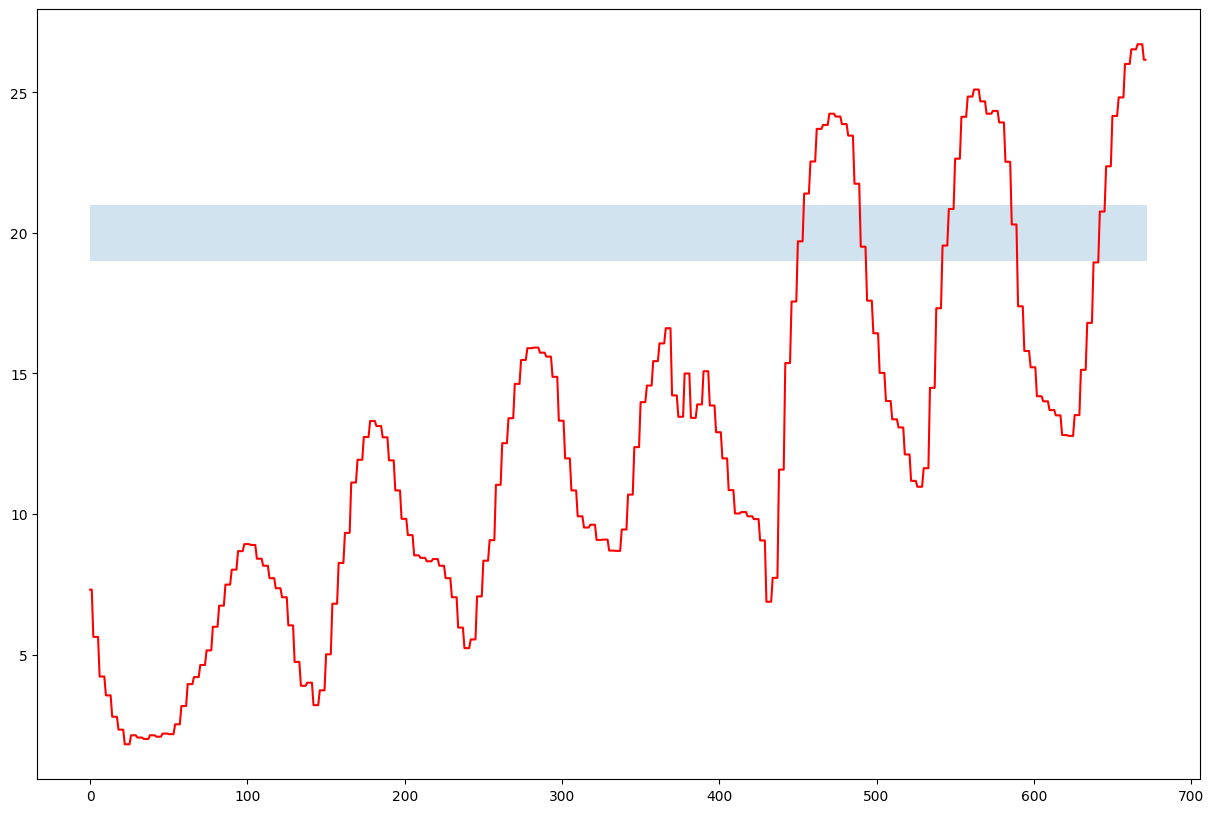

In [45]:
print(results_task2.keys())
for i,result in enumerate(results_task2["0.5"]):
    N = len(result["outside_temps"])

    # 1) Cout minimal
    print("Optimal Total Cost: ", result["totalCost"])
    print("Max budget: ", result["maxBudget"])
    print("Total inconfort: ", result["totalInconfort"])
    print(f"Temps de calcul: { result['calcDuration'] }s")

    # 2) Graphe des températures extérieures et intérieures
    x = range(N)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2))
    ax.plot(x, result["outside_temps"], label="Température extérieure", color="red")
    ax.plot(x, result["optimal_inside_temps"], label="Température intérieure", color="blue")
    ax.add_patch(plt.Rectangle((0, T_MIN), N, (T_MAX - T_MIN), alpha=.2, color="green", label=f"Températures entre {T_MIN}°C et {T_MAX}°C"))
    plt.legend()
    plt.title("Températures extérieures et intérieures")
    plt.xlabel("Intervalles")
    plt.savefig(f"./graphs/task2_temp_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # 3) Graphe de l'utilisation de la pompe à chaleur
    x = range(N)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(x, result["optimal_heat_pump_power_normal"], label="Mode normal", color="red")
    ax.bar(x, result["optimal_heat_pump_power_reverse"], label="Mode reverse", color="blue")
    plt.legend()
    plt.title("Utilisation de la pompe en KW/h")
    plt.xlabel("interval")
    plt.savefig(f"./graphs/task2_usage_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    print("-----------------------------------")

<div class="alert alert-block alert-info"><b>Question 2.4</b> :<br> 
    Pour terminez cette partie, résolvez encore une fois ce nouveau modèle, mais cette fois de façon exacte, en utilisant un solveur quadratique. Comparez avec la solution approchée obtenue précédemment (allure de la solution, temps de calcul).
</div>

In [ ]:
# TODO !

**Tâche 3** : on voudrait à présent mieux comprendre le compromis qui existe entre le budget alloué et l'inconfort total qui en résulte. Proposez un **graphique représentant au mieux cette relation entre budget et inconfort**, où on fera varier le budget entre entre zéro et le coût minimal identifié lors de la tâche 1 (ce budget sera indiqué en pourcentage, de 0 à 100%). Ceci nécessitera la résolution de plusieurs problèmes, et il sera judicieux d'utiliser la fonctionnalité _warm start_ du solver pour accélérer les calculs.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- graphique demandé + temps de calcul (total et moyenne par problème) + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées  lors des tâches 1 et 2
</div>

---

<div class="alert alert-block alert-info"><b>Question 3.1</b> :<br> 
    Fournissez le graphique et les commentaires demandé ci-dessus
</div>

In [ ]:
# TODO !

<div class="alert alert-block alert-info"><b>Question 3.2</b> :<br> 
    Expliquez la pente linéaire observée dans une grande partie du graphique obtenu. Recalculez la valeur de la pente à partir des informations fournies par le solver pour la résolution avec le budget maximal (tâche 2 initiale, Question 2.2), et comparez à celle du graphique. Enfin, expliquez pourquoi le graphique cesse à un moment d'être une droite.
</div>

In [ ]:
# TODO !

---


<div class="alert alert-block alert-info"><b>Bonus</b><br>
    Estimez l'effet de l'utilisation d'une version imprécise des données de température (prévisions)<br>
</div>
Ce bonus est optionnel, et ne conduit pas à l'obtention de points supplémentaires : il est seulement destiné à attirer votre
    attention sur le caractère artificiel de la situation proposée, où on connaît parfaitement et à l'avance les températures extérieures.

## Consignes et conseils
- Le projet se réalise par groupe de (maximum) quatre étudiants (cf. groupes constitués sur Moodle). 

- L'assistant responsable du projet est Guillaume Van Dessel. Toutes les  questions sur le projet doivent être posées via Moodle dans le forum prévu pour le projet (et pas par message/mail individuel). Des permanences seront prévues, et seront annoncées via Moodle.

- Il est fortement suggéré d'utiliser un langage de modélisation pour formuler et résoudre vos problèmes d'optimisation linéaire. Nous conseillons d'utiliser le module CVXPY combiné au solver d'optimisation HIGHS (nous avons vérifié que cette combinaison est suffisamment performance pour le projet).

- Les groupes peuvent échanger leurs réflexions, partager leurs idées et comparer leurs résultats. Ils ne peuvent pas recopier les raisonnements, les solutions ou les codes informatiques. L'utilisation de toute information ou aide extérieure doit obligatoirement être mentionnée dans le rapport, en citant la source.

- Votre rapport final sera constitué de ce notebook complété, où vous aurez inséré vos codes, vos résultats, vos graphiques et commentaires.

- Ce rapport  est à remettre au plus tard le **mercredi 24 mai 2023** à minuit (soir), via Moodle, sous la forme d'une archive compressée contenant votre notebook et tous les fichiers nécessaires pour le faire fonctionner (code Python, etc.). Le notebook doit contenir les cellules sous forme déjà évaluée (résultats, tableaux, graphiques, etc.), mais doit pouvoir également être ré-évalué en entier. 

- Organisez efficacement votre travail de groupe, et répartissez vous le travail. Les tâches à effectuer durant cette seconde partie sont *largement indépendantes* les unes des autres.


### Changelog
- 2023-03-24 v1
- 2023-04-23 v1.1 avec récapitulatif des précisions apportées sur Moodle (en bleu)
- 2023-04-28 description des tâches de la seconde partie
- 2023-05-12 v2 avec le format attendu (notebook) pour le rapport final
- 2023-05-12 v2.1 précisions supplémentaire pour quelques questions